# Setup

In [1]:
import random
import string
import os

from pylibdmtx.pylibdmtx import encode, decode, DmtxSymbolSize
from PIL import Image, ImageChops

from torchvision.transforms import v2

import numpy as np
import math

# Setting Parameters

To synthesize the dataset the following parameters and amounts will be used:

- 20 randomized strings in following letter (L) number (N) format:
    - NLNLNNNNNNN + NNNN
    - \+ NNNN denotes the last 4 numbers in a serial number which increment by 1. Therefore this will range from 0000 to 0100 to mimic the real-world data more closely.
- 20 configurations of shape transformations of the following types:
    - random horizontal flip
    - random vertical flip
    - random rotation
    - random affine
    - random perspective
- 5 different scalings between 0-1
- 20 configurations of color transformations of the following types:
    - color jitter
    - random photometric distort
    - random grayscale
    - gaussian blur
    - gaussian noise
    - random invert
    - random adjust sharpness

This will lead to $20*20*5*20*2 = 80,000$ images being generated (40,000 ground truth and 40,000 noisy data).

## Helpers

These helpers do each individual part of the pipeline

In [2]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''
    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))
    
    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode):
    '''Creates a PIL image containing DMC encoding of given string'''
    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels).convert('L')
    img = img.crop((10, 10, img.width-10, img.height-10)) # crop image to remove white borders
    img = img.resize((img.width*10, img.height*10), Image.BILINEAR) # upscale image
    return img

def shape_transform(img):
    '''Applies random shape transformations to image'''

    # Calculate padding for random affine
    width, height = img.size
    diagonal = math.sqrt(width**2 + height**2)
    padding = math.ceil((diagonal - width) / 2)

    transforms = v2.Compose([
        v2.Pad(padding, fill=255, padding_mode='constant'),
        # v2.RandomHorizontalFlip(),
        # v2.RandomVerticalFlip(),
        v2.RandomRotation(random.randrange(0, 360), fill=255, interpolation=Image.BILINEAR, expand=True),
        v2.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=Image.BILINEAR, fill=255),
        v2.RandomAffine(degrees=0,
                        # translate=(0.2, 0.2), # random "shift" on x and y axis
                        # scale=(0.5, 1.5), # randomly scale image size between 0.5 and 1.5
                        # random "squish" on x and y axis
                        shear=(-random.randrange(10,20), random.randrange(10,20), -random.randrange(10,20), random.randrange(10,20)),
                        fill=255,
                        interpolation=Image.BILINEAR,
                        ),
    ])

    img = transforms(img)

    # crop image down to black pixels
    coords = np.argwhere(np.array(img) < 255)
    top_left = coords.min(axis=0)
    bottom_right = coords.max(axis=0) + 1 # +1 to include last pixel
    img = img.crop((top_left[1], top_left[0], bottom_right[1], bottom_right[0]))
    
    # resize image to original size
    img = img.resize((width, height), Image.BILINEAR)

    return img

def combine_texture(img, texture_path, increment):
    '''
    Blends img with a random texture image from texture_path
    takes a random crop of the texture
    resizes texture to match img size
    '''
    texture = Image.open(texture_path)

    # random crop with pytorch RandomCrop
    crop_size = int(0.5 * min(texture.size)) # crop size based on texture size
    transforms = v2.Compose([
        v2.RandomCrop(size=(crop_size, crop_size)), # smallest resolution image is 1280 x 1024
    ])
    texture = transforms(texture)
    texture = texture.resize(img.size, Image.BILINEAR)

    # increase brightness of img
    img = np.array(img, dtype=np.int16)
    img = np.clip(img + increment, 0, 255)
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img = img.convert('RGB')
    
    blended = ImageChops.multiply(texture, img)

    return blended

def color_transform(img):
    '''
    Applies random color transformations to image
    Parameters chosen to be within a realistic range similar to real world images
    '''
    # random kernel size for gaussian blur
    kernel_size = random.choice([7, 9, 11])

    transforms = v2.Compose([
        v2.ColorJitter(brightness = (0.8, 1.2),  # small range as extreme lighting is not so present in real world
                       contrast   = (0.8, 1.5),  # wider range as contrast occurs in more examples
                       saturation = (0.8, 1.2),  # small range
                       hue        = (-0.1, 0.1), # idk
                       ),
        v2.RandomPhotometricDistort(brightness = (0.8, 1.2),
                                    contrast   = (0.7, 1.3),
                                    saturation = (0.8, 1.2),
                                    hue        = (-0.05, 0.05),
                                    ),
        v2.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 100.0)), # chance to blur a lot or a little - mostly an ok amount
        # v2.RandomSolarize(0.5, 0.5), # NOT USED as it may interfere with binarizer learning and white on black is not common
    ])

    img = transforms(img)
    return img

## Main Function

"gen_imgs" takes in params and uses helpers to synthesize both the ground truth and noisy images

In [3]:
def gen_imgs(N_imgs, texture_path):
    '''Generates N images'''
    i = min([len(os.listdir('../data/synth_data/ground_truth/')), len(os.listdir('../data/synth_data/noisy/'))])
    while i < N_imgs:

        # generate string to encode into DMC
        to_encode = gen_string()
        dmc_img = encode_image(to_encode)
        # display(dmc_img)
        # break

        # generate shape transformed DMC
        shape_img = shape_transform(dmc_img)

        # convert ground truth to binary
        ground_truth = shape_img.point(lambda p: 0 if p < 128 else 255) # 128 is a good threshold
        # display(ground_truth)
        # break

        # check if image can be decoded, if not, regenerate (this forces us to only generate decodable images)
        decoded = decode(ground_truth,
                         max_count=1,
                         threshold=50,
                         min_edge= 20,
                         max_edge=800,
                         shape=DmtxSymbolSize.DmtxSymbol16x16,
                         timeout=1000,
                         )
        if not decoded:
            continue

        # save ground truth
        ground_truth.save(f'../data/synth_data/ground_truth/{to_encode}.png')

        # display(ground_truth)
        # break

        # blend into metal texture
        texture = f'{os.path.dirname(texture_path)}/{random.choice(os.listdir(texture_path))}'
        increment = random.randint(10, 175)
        blended_img = combine_texture(ground_truth, texture, increment)
        # display(blended_img)
        # break

        # generate colored DMC
        color_img = color_transform(blended_img)

        # display(color_img)
        # display(ground_truth)
        # break

        # save ground noisy image
        color_img.save(f'../data/synth_data/noisy/{to_encode}.png')

        # print progress
        if i % 100 == 0:
            print(f'{i}/{N_imgs}', end='\r')

        # testing
        # if i != 0 and i % 100 == 0:
        #     break

        i += 1
    return

# on average, the size of a pair of color_img and ground_truth iamges are 600KB
# so the total size of the dataset will be 10,000 * 600KB = 6,000,000KB = ~6GB

# generates randomized imgs until N_imgs are present in the dataset
N_imgs = 10000
gen_imgs(N_imgs, texture_path = '../data/textures/')

In [4]:
# confirm that the number of images generated is correct - and delete mismatching images
ground_truth_imgs = os.listdir('../data/synth_data/ground_truth/')
noisy_imgs = os.listdir('../data/synth_data/noisy/')

if len(ground_truth_imgs) != len(noisy_imgs):
    print('Mismatching images found, deleting...')
    for img in ground_truth_imgs:
        if img not in noisy_imgs:
            os.remove(f'../data/synth_data/ground_truth/{img}')
    for img in noisy_imgs:
        if img not in ground_truth_imgs:
            os.remove(f'../data/synth_data/noisy/{img}')
    print('Mismatching images deleted')

[Decoded(data=b'0A0M64326720078', rect=Rect(left=276, top=0, width=286, height=808))]
True


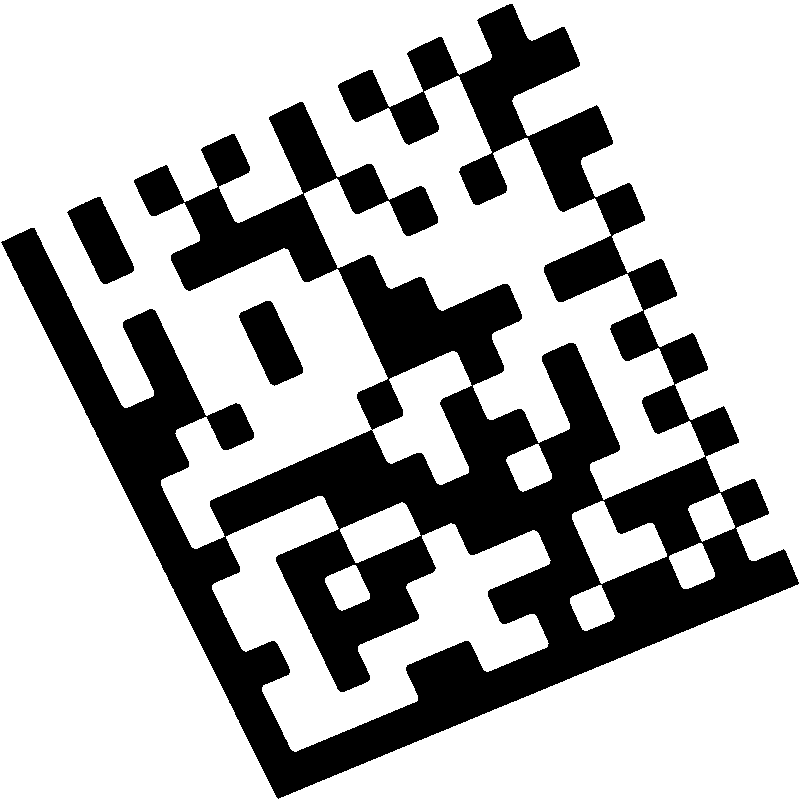

In [5]:
# decode test with single image
images = os.listdir('../data/synth_data/ground_truth/')
image = Image.open(f'../data/synth_data/ground_truth/{images[0]}')

decoded = decode(image,
                 max_count=1,
                 threshold=50,
                 min_edge= 20,
                 max_edge=800,
                 shape=DmtxSymbolSize.DmtxSymbol16x16,
                 timeout=1000,
                 )

print(decoded)
if decoded:
    print(True)
else:
    print(False)

display(image)

In [6]:
# confirming that we can decode ground_truth images
decode_count = 0
images = os.listdir('../data/synth_data/ground_truth/')
for idx, img in enumerate(images, start=1):
    img = Image.open(f'../data/synth_data/ground_truth/{img}')
    decoded = decode(img,
                     max_count=1,
                     threshold=50,
                     min_edge= 20,
                     max_edge=800,
                     shape=DmtxSymbolSize.DmtxSymbol16x16,
                     timeout=1000,
                     )
    if decoded:
        decode_count += 1

    print(f'{idx}/{len(images)} ===== decode_count: {decode_count}', end='\r')

In [7]:
# confirming that we cannot decode (most) noisy images
decode_count = 0
images = os.listdir('../data/synth_data/noisy/')
for idx, img in enumerate(images, start=1):
    img = Image.open(f'../data/synth_data/noisy/{img}')
    decoded = decode(img,
                     max_count=1,
                     threshold=50,
                     min_edge= 20,
                     max_edge=800,
                     shape=DmtxSymbolSize.DmtxSymbol16x16,
                     timeout=1000,
                     )
    if decoded:
        decode_count += 1
    
    print(f'{idx}/{len(images)} ===== decode_count: {decode_count}', end='\r')